In [1]:
import pandas as pd
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

In [2]:
# Log files data
file_path = './log-files-results.csv'
data = pd.read_csv(file_path)

In [3]:
# Define box plot variables for colors and sizes
box_colors = ['white', 'white']
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
box_width = 0.8
mean_color = 'hotpink'

In [4]:
# Speed test
ghost_joystick = data[(data["Task type"] == "GHOST") & (data["Controller"] == "JOYSTICK")]["Completion Time (s)"]
ghost_miniature = data[(data["Task type"] == "GHOST") & (data["Controller"] == "MINIATURE")]["Completion Time (s)"]

bucket_joystick = data[(data["Task type"] == "BUCKET") & (data["Controller"] == "JOYSTICK")]["Completion Time (s)"]
bucket_miniature = data[(data["Task type"] == "BUCKET") & (data["Controller"] == "MINIATURE")]["Completion Time (s)"]

# Perform the Wilcoxon Signed-Rank Test for each task type
ghost_test_result = wilcoxon(ghost_joystick.dropna(), ghost_miniature.dropna(), alternative="greater")
bucket_test_result = wilcoxon(bucket_joystick.dropna(), bucket_miniature.dropna(), alternative="greater")

ghost_test_result, bucket_test_result


(WilcoxonResult(statistic=135.0, pvalue=0.0151824951171875),
 WilcoxonResult(statistic=138.0, pvalue=0.010406494140625))

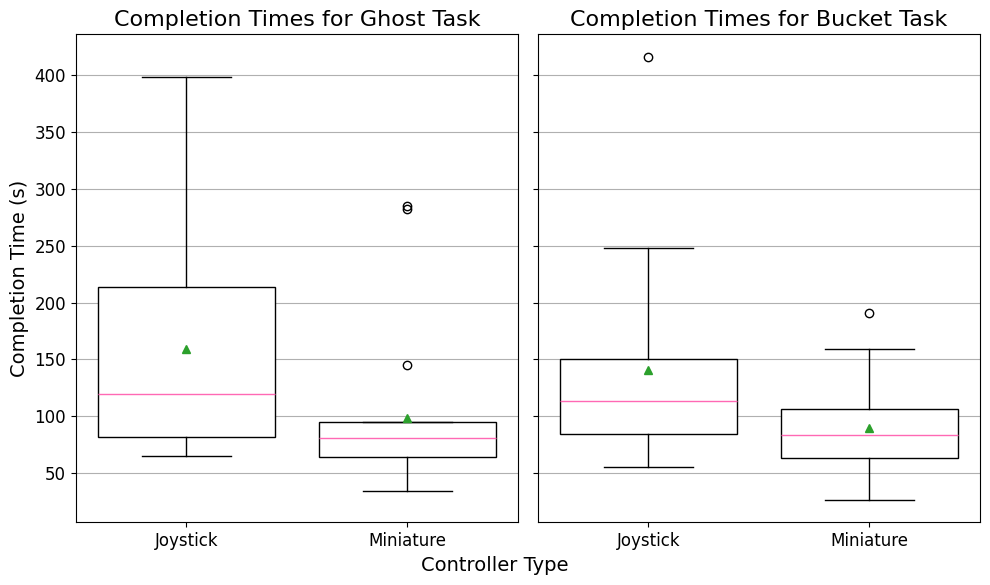

In [5]:
# Prepare data for boxplots
ghost_data = [ghost_joystick.dropna(), ghost_miniature.dropna()]
bucket_data = [bucket_joystick.dropna(), bucket_miniature.dropna()]

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Boxplot for GHOST task
bplot1 = axes[0].boxplot(
    ghost_data, 
    tick_labels=["Joystick", "Miniature"], 
    patch_artist=True,
    showmeans=True, 
    widths=box_width
)

for median in bplot1['medians']:
    median.set_color(mean_color)
    
axes[0].set_title("Completion Times for Ghost Task", fontsize=title_fontsize)
axes[0].set_ylabel("Completion Time (s)", fontsize=label_fontsize)
axes[0].grid(axis='y')
axes[0].tick_params(axis='x', labelsize=tick_fontsize)
axes[0].tick_params(axis='y', labelsize=tick_fontsize)

# Apply custom colors to GHOST task box plot
for patch, color in zip(bplot1['boxes'], box_colors):
    patch.set_facecolor(color)

# Boxplot for BUCKET task
bplot2 = axes[1].boxplot(
    bucket_data, 
    tick_labels=["Joystick", "Miniature"], 
    showmeans=True,
    patch_artist=True,
    widths=box_width
)

for median in bplot2['medians']:
    median.set_color(mean_color)
    
axes[1].set_title("Completion Times for Bucket Task", fontsize=title_fontsize)
axes[1].grid(axis='y')
axes[1].tick_params(axis='x', labelsize=tick_fontsize)
axes[1].tick_params(axis='y', labelsize=tick_fontsize)

# Apply custom colors to BUCKET task box plot
for patch, color in zip(bplot2['boxes'], box_colors):
    patch.set_facecolor(color)

# Add a common x-axis label
fig.text(0.5, 0.04, "Controller Type", ha='center', fontsize=label_fontsize)

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Add space for the x-axis label
plt.show()


In [6]:
# Calculate summary statistics (median, mean, std, min, max) for completion times grouped by Task and Controller
summary_stats = data.groupby(['Task type', 'Controller'])['Completion Time (s)'].agg(
    ['mean', 'median', 'std', 'min', 'max', 'count']
).reset_index()

summary_stats['range'] = summary_stats['max'] - summary_stats['min']

summary_stats

,Task type,Controller,mean,median,std,min,max,count,range
0,BUCKET,JOYSTICK,140.408553,113.029651,89.197166,55.231274,416.610593,18,361.379319
1,BUCKET,MINIATURE,89.665325,83.247836,45.397705,26.132825,191.049150,18,164.916325
2,GHOST,JOYSTICK,159.141362,119.164292,101.447960,64.911401,398.685334,18,333.773933
3,GHOST,MINIATURE,98.394768,80.577682,72.540526,34.094057,285.282054,18,251.187997


In [7]:
# Accuracy test

# GHOST task - differences in angles
ghost_joystick_accuracy = data[(data["Task type"] == "GHOST") & (data["Controller"] == "JOYSTICK")][
    ["Swing Diff", "Boom Diff", "Stick Diff", "Bucket Diff"]
].dropna()
ghost_miniature_accuracy = data[(data["Task type"] == "GHOST") & (data["Controller"] == "MINIATURE")][
    ["Swing Diff", "Boom Diff", "Stick Diff", "Bucket Diff"]
].dropna()

# BUCKET task - distance
bucket_joystick_accuracy = data[(data["Task type"] == "BUCKET") & (data["Controller"] == "JOYSTICK")]["Distance"].dropna()
bucket_miniature_accuracy = data[(data["Task type"] == "BUCKET") & (data["Controller"] == "MINIATURE")]["Distance"].dropna()

# Perform the Wilcoxon Signed-Rank Test for GHOST task (each angle difference)
ghost_results = {}
for col in ghost_joystick_accuracy.columns:
    test_result = wilcoxon(
        ghost_joystick_accuracy[col],
        ghost_miniature_accuracy[col],
        alternative="greater"  # Lower difference is better
    )
    ghost_results[col] = test_result

# Perform the Wilcoxon Signed-Rank Test for BUCKET task
bucket_test_result = wilcoxon(
    bucket_joystick_accuracy, bucket_miniature_accuracy, alternative="greater"  # Lower distance is better
)

ghost_results, bucket_test_result


({'Swing Diff': WilcoxonResult(statistic=136.0, pvalue=0.013423919677734375),
  'Boom Diff': WilcoxonResult(statistic=131.0, pvalue=0.024139404296875),
  'Stick Diff': WilcoxonResult(statistic=121.0, pvalue=0.06486892700195312),
  'Bucket Diff': WilcoxonResult(statistic=98.0, pvalue=0.3047294616699219)},
 WilcoxonResult(statistic=123.0, pvalue=0.05419158935546875))

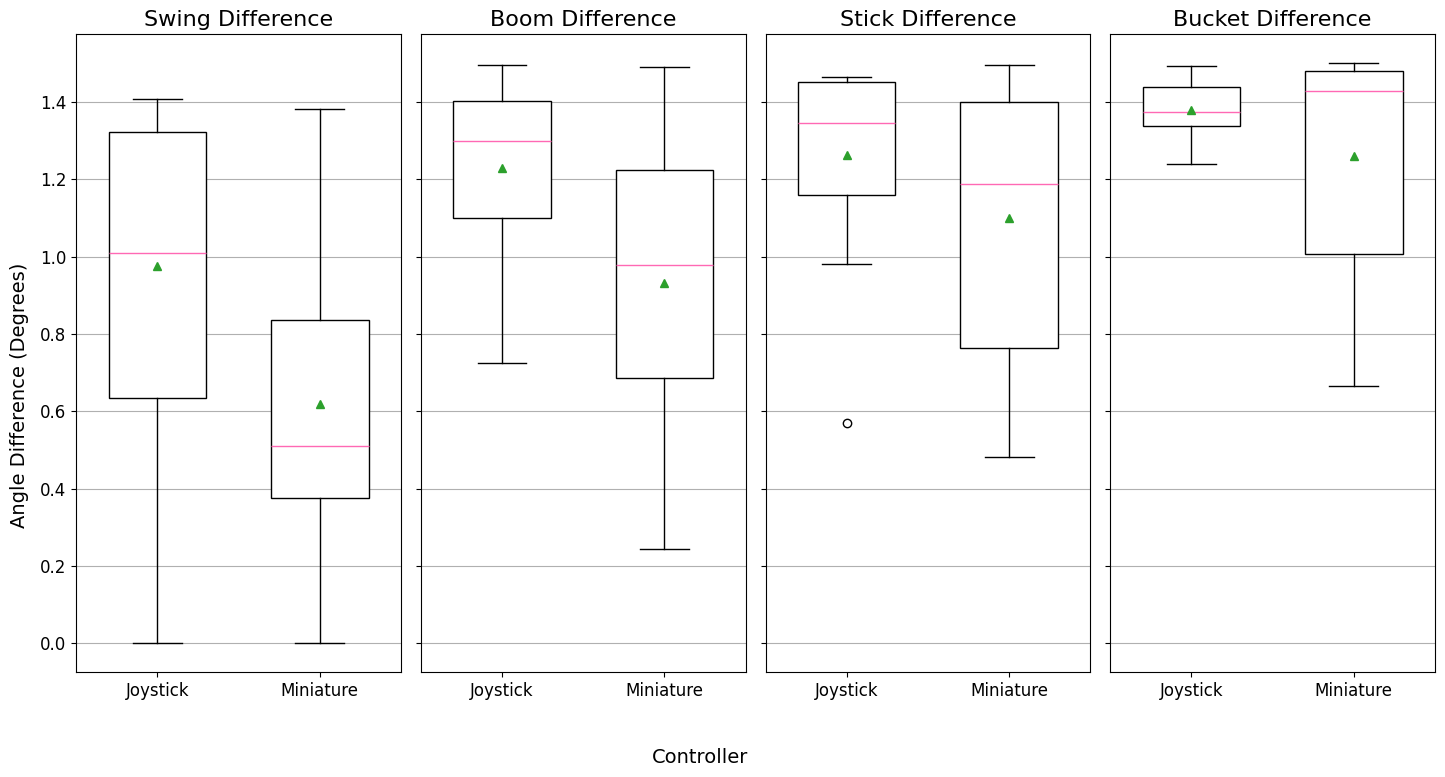

In [8]:
box_width = 0.6

# GHOST task accuracy metrics
ghost_data = {
    "Swing Difference": [ghost_joystick_accuracy["Swing Diff"], ghost_miniature_accuracy["Swing Diff"]],
    "Boom Difference": [ghost_joystick_accuracy["Boom Diff"], ghost_miniature_accuracy["Boom Diff"]],
    "Stick Difference": [ghost_joystick_accuracy["Stick Diff"], ghost_miniature_accuracy["Stick Diff"]],
    "Bucket Difference": [ghost_joystick_accuracy["Bucket Diff"], ghost_miniature_accuracy["Bucket Diff"]],
}

# Create a single row of 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 8), sharey=True)

# Generate box plots for each metric
for ax, (metric, values) in zip(axes, ghost_data.items()):
    bplot = ax.boxplot(
        values,
        tick_labels=["Joystick", "Miniature"],
        showmeans=True,
        patch_artist=True,  # Enables custom colors
        widths=box_width
    )
    for median in bplot['medians']:
        median.set_color(mean_color)
        
    ax.set_title(metric, fontsize=title_fontsize)
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)
    ax.grid(axis='y')

    # Apply custom colors: Left box (Joystick) -> first color, Right box (Miniature) -> second color
    for patch, color in zip(bplot['boxes'], box_colors):
        patch.set_facecolor(color)

# Set a common y-label to the left of the entire row of plots
fig.text(0.04, 0.5, "Angle Difference (Degrees)", va='center', rotation='vertical', fontsize=label_fontsize)

# Set a common x-label below all plots
fig.text(0.5, 0.04, "Controller", ha='center', fontsize=label_fontsize)

# Adjust spacing between plots
plt.tight_layout(rect=[0.05, 0.1, 1, 1])  # Leave space for the x-label and y-label
plt.show()

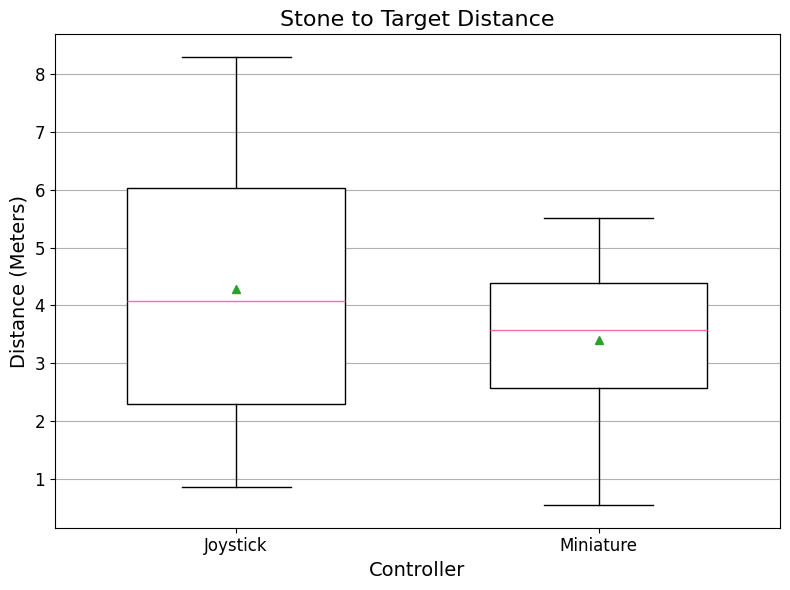

In [9]:
# BUCKET task accuracy metrics
bucket_data = {
    "Distance (Meters)": [bucket_joystick_accuracy, bucket_miniature_accuracy]
}

# Create a single row of subplots (only 1 for BUCKET task in this case)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Generate box plot for BUCKET task
bplot = ax.boxplot(
    bucket_data["Distance (Meters)"],
    tick_labels=["Joystick", "Miniature"],
    showmeans=True,
    patch_artist=True,  # Enables custom colors
    widths=box_width
)

for median in bplot['medians']:
        median.set_color(mean_color)

ax.set_title("Stone to Target Distance", fontsize=title_fontsize)
ax.set_xlabel("Controller", fontsize=label_fontsize)
ax.set_ylabel("Distance (Meters)", fontsize=label_fontsize)
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.grid(axis='y')

# Apply custom colors: Left box (Joystick) -> first color, Right box (Miniature) -> second color
for patch, color in zip(bplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Adjust layout
plt.tight_layout()
plt.show()

In [10]:
# Error test

# Create a contingency table for errors
# Convert error counts into binary outcomes: 0 = No error, 1 = At least one error
bucket_joystick_errors = data[(data["Task type"] == "BUCKET") & (data["Controller"] == "JOYSTICK")]["Errors"].fillna(0)
bucket_miniature_errors = data[(data["Task type"] == "BUCKET") & (data["Controller"] == "MINIATURE")]["Errors"].fillna(0)

# Calculate summary statistics (mean, median, std, min, max) for errors grouped by Controller
summary_stats = data[data["Task type"] == "BUCKET"].groupby("Controller")["Errors"].agg(
    ["mean", "median", "std", "min", "max", "count"]
).reset_index()

summary_stats["range"] = summary_stats["max"] - summary_stats["min"]

print("Summary Statistics for Errors:")
print(summary_stats)

# Binarize error data
joystick_binary = np.where(bucket_joystick_errors > 0, 1, 0)
miniature_binary = np.where(bucket_miniature_errors > 0, 1, 0)

# Create a 2x2 contingency table
# Rows: Joystick (Error/No Error), Columns: Miniature (Error/No Error)
contingency_table = np.zeros((2, 2), dtype=int)
contingency_table[0, 0] = np.sum((joystick_binary == 0) & (miniature_binary == 0))  # No error with either
contingency_table[0, 1] = np.sum((joystick_binary == 0) & (miniature_binary == 1))  # Error with Miniature only
contingency_table[1, 0] = np.sum((joystick_binary == 1) & (miniature_binary == 0))  # Error with Joystick only
contingency_table[1, 1] = np.sum((joystick_binary == 1) & (miniature_binary == 1))  # Error with both

# Perform McNemar's Test
mcnemar_result = mcnemar(contingency_table, exact=True)

print("McNemar's Test Result:")
print(mcnemar_result)


Summary Statistics for Errors:
  Controller      mean  median       std  min  max  count  range
0   JOYSTICK  0.111111     0.0  0.471405  0.0  2.0     18    2.0
1  MINIATURE  0.944444     0.0  1.258955  0.0  4.0     18    4.0
McNemar's Test Result:
pvalue      0.015625
statistic   0.0


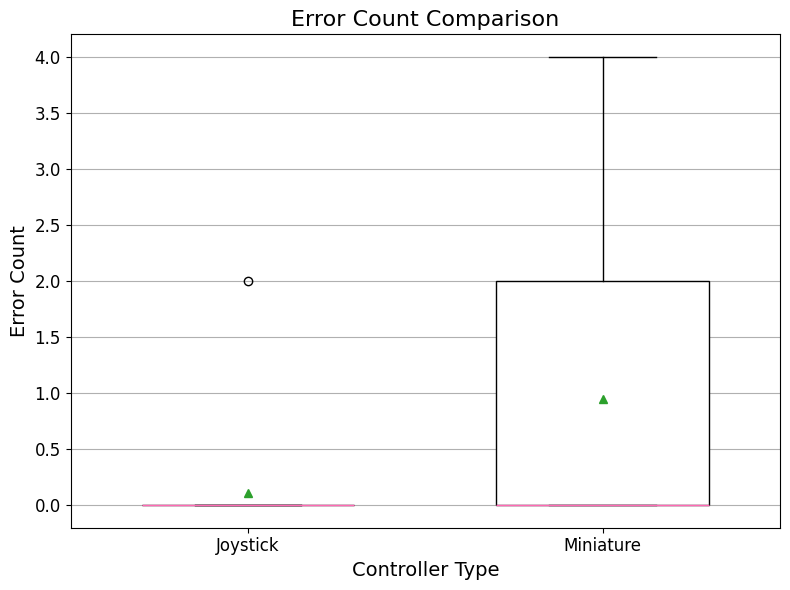

In [11]:
# Boxplot for raw error counts
plt.figure(figsize=(8, 6))
bplot = plt.boxplot(
    [bucket_joystick_errors, bucket_miniature_errors],
    tick_labels=["Joystick", "Miniature"],
    showmeans=True,
    patch_artist=True,  # Enables custom colors
    widths=box_width
)

for median in bplot['medians']:
        median.set_color(mean_color)

# Apply custom colors to the boxes
for patch, color in zip(bplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set titles and labels
plt.title("Error Count Comparison", fontsize=title_fontsize)
plt.ylabel("Error Count", fontsize=label_fontsize)
plt.xlabel("Controller Type", fontsize=label_fontsize)

# Customize ticks and grid
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(axis="y")

# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
# Cognitive workload test

file_path = './questionnaires-results.csv'
data = pd.read_csv(file_path)

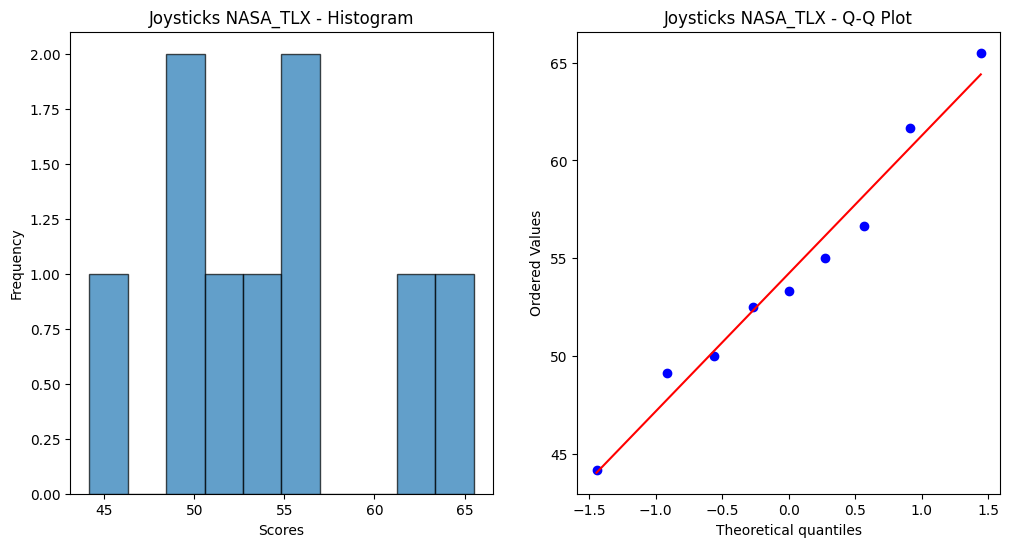

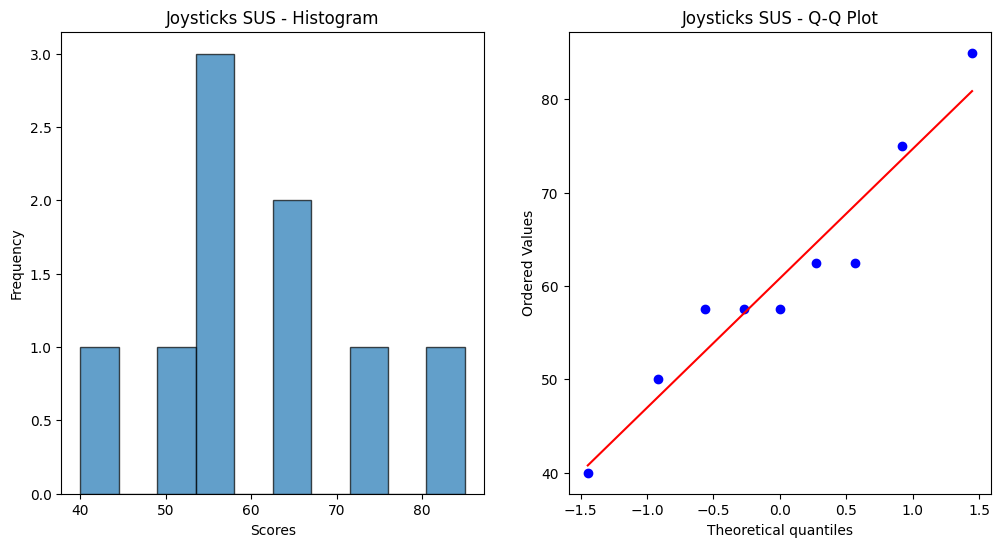

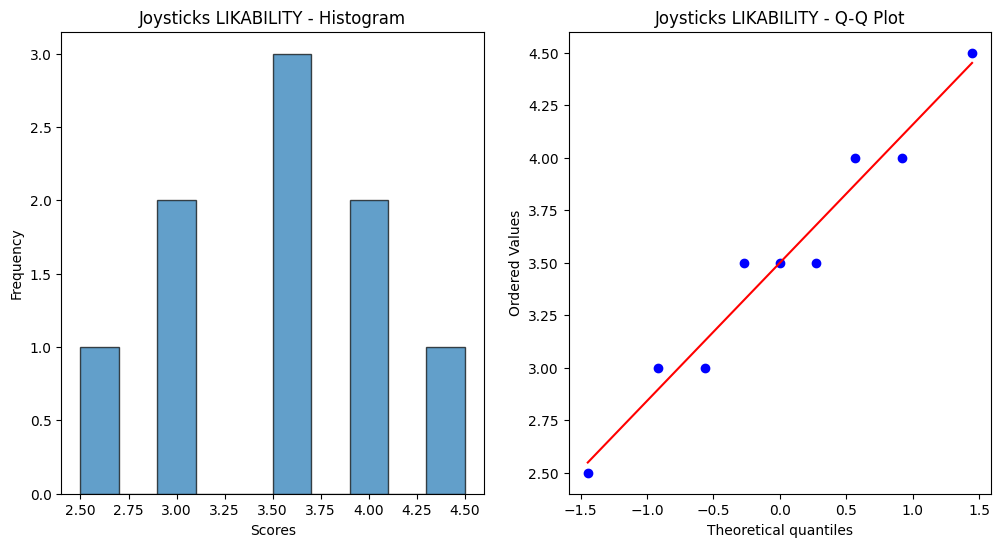

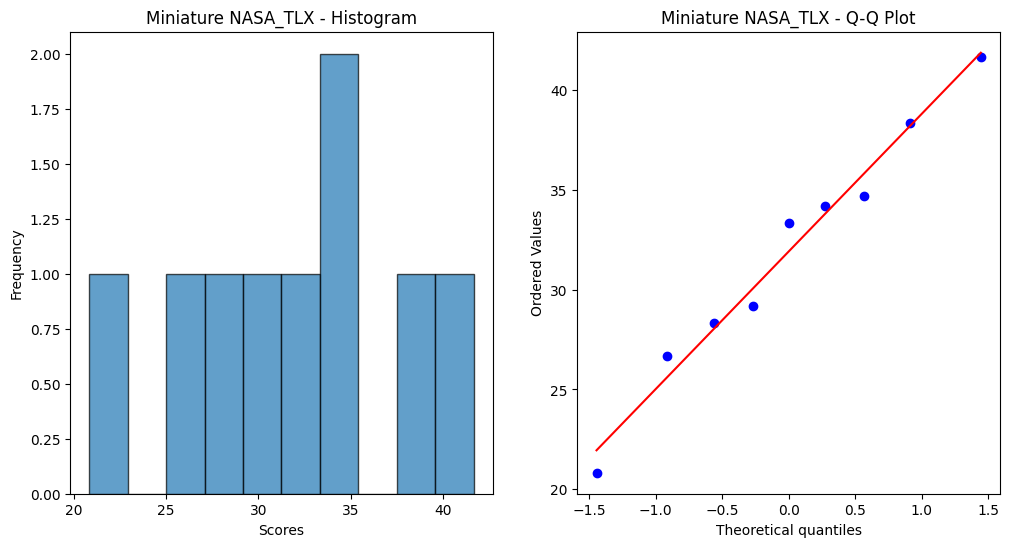

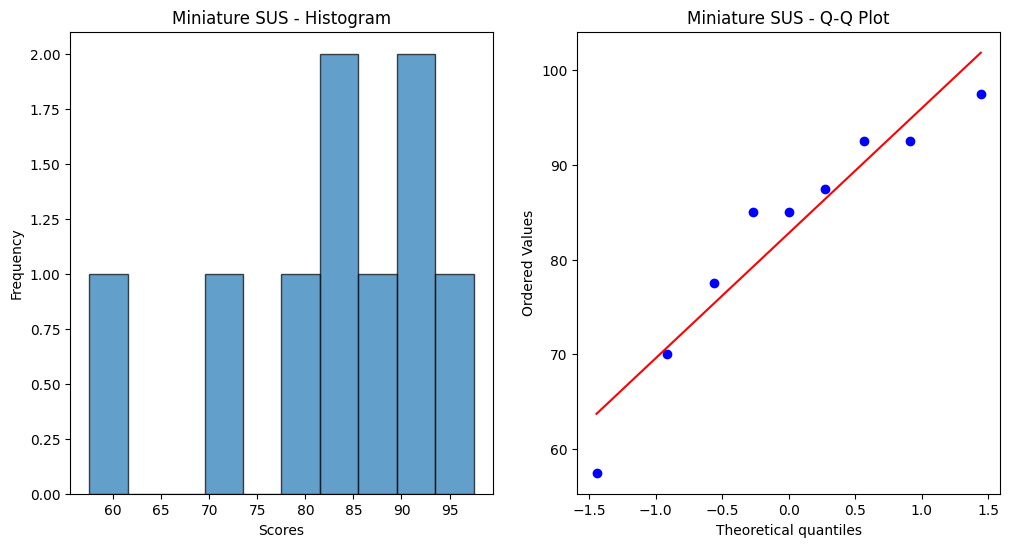

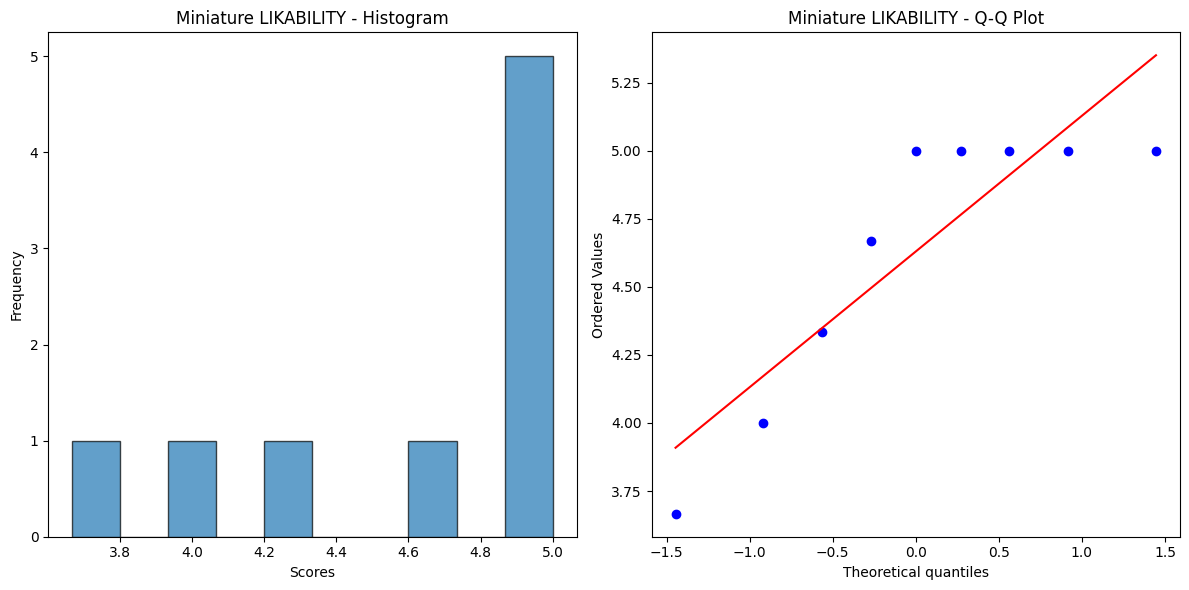

{'Joysticks NASA_TLX': (0.9783861086945349, 0.9554610184451233),
 'Joysticks SUS': (0.9458701605409785, 0.6448559808192744),
 'Joysticks LIKABILITY': (0.9630724410927188, 0.8298693879556072),
 'Miniature NASA_TLX': (0.9825784470107825, 0.976215338649348),
 'Miniature SUS': (0.9144837875625409, 0.3485295294497153),
 'Miniature LIKABILITY': (0.7721113969807158, 0.009769976157321936)}

In [13]:
## Check for normal distribution

joystick_data = data[data['Control System'] == 'JOYSTICKS']
miniature_data = data[data['Control System'] == 'MINIATURE']

def check_normality(column, label):
    plt.figure(figsize=(12, 6))
    
    # Plot histogram
    plt.subplot(1, 2, 1)
    plt.hist(column, bins=10, alpha=0.7, edgecolor='black')
    plt.title(f'{label} - Histogram')
    plt.xlabel('Scores')
    plt.ylabel('Frequency')
    
    # Plot Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(column, dist="norm", plot=plt)
    plt.title(f'{label} - Q-Q Plot')
    
    # Shapiro-Wilk test for normality
    stat, p_value = stats.shapiro(column)
    return stat, p_value

results = {}

for category, group_data in zip(
    ['Joysticks', 'Miniature'],
    [joystick_data, miniature_data]
):
    results[f'{category} NASA_TLX'] = check_normality(group_data['NASA_TLX'], f'{category} NASA_TLX')
    results[f'{category} SUS'] = check_normality(group_data['SUS'], f'{category} SUS')
    results[f'{category} LIKABILITY'] = check_normality(group_data['LIKABILITY'], f'{category} LIKABILITY')

plt.tight_layout()
plt.show()

results

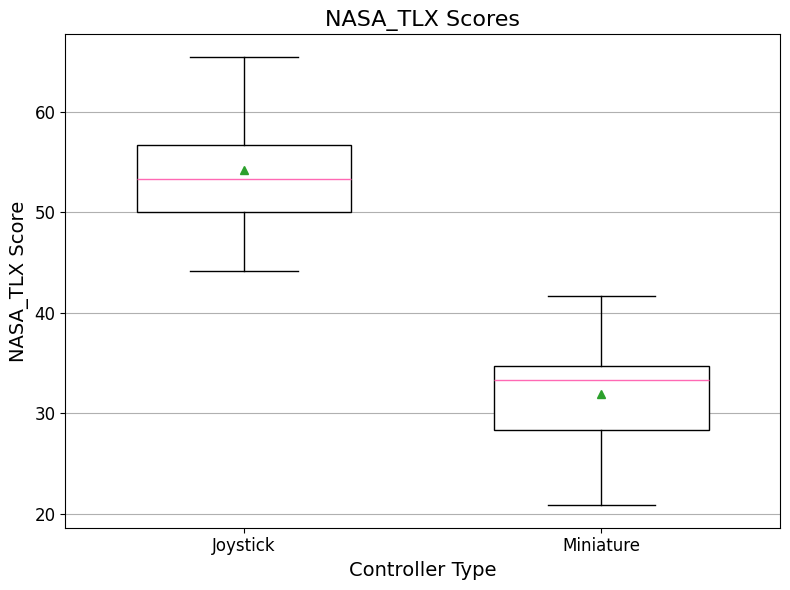

In [14]:
# Extract the data as lists
joystick_scores = data[data['Control System'] == 'JOYSTICKS']['NASA_TLX'].dropna().tolist()
miniature_scores = data[data['Control System'] == 'MINIATURE']['NASA_TLX'].dropna().tolist()

# Boxplot for NASA-TLX scores
plt.figure(figsize=(8, 6))

# Create boxplot
bplot = plt.boxplot(
    [joystick_scores, miniature_scores],
    tick_labels=['Joystick', 'Miniature'],
    showmeans=True,
    patch_artist=True,  # Enables custom colors
    widths=box_width
)

# Customize the medians
for median in bplot['medians']:
    median.set_color(mean_color)

# Apply custom colors to the boxes
for patch, color in zip(bplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set titles and labels
plt.title("NASA_TLX Scores", fontsize=title_fontsize)
plt.ylabel("NASA_TLX Score", fontsize=label_fontsize)
plt.xlabel("Controller Type", fontsize=label_fontsize)

# Customize ticks and grid
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(axis="y")

# Adjust layout
plt.tight_layout()
plt.show()


In [15]:
# Extract SUS scores for paired t-test
sus_joysticks = data[data['Control System'] == 'JOYSTICKS']['SUS'].dropna()
sus_miniature = data[data['Control System'] == 'MINIATURE']['SUS'].dropna()

# Perform paired t-test
t_test_sus = ttest_rel(sus_joysticks, sus_miniature)

t_test_sus


TtestResult(statistic=-4.587908442698423, pvalue=0.0017834413578471057, df=8)

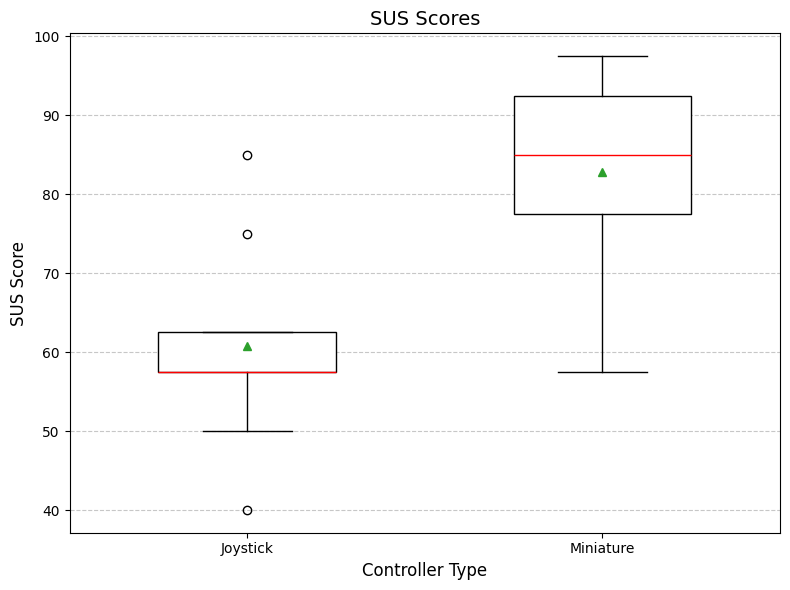

{'t-statistic': -4.587908442698423, 'p-value': 0.0017834413578471057}


In [16]:

# Customization options
box_width = 0.5  # Width of boxplots
mean_color = 'red'  # Color for means
title_fontsize = 14
label_fontsize = 12
tick_fontsize = 10

# Boxplot for SUS scores
sus_scores = [sus_joysticks, sus_miniature]
controllers = ['Joystick', 'Miniature']

plt.figure(figsize=(8, 6))

# Create SUS boxplot
bplot = plt.boxplot(
    sus_scores,
    tick_labels=controllers,
    patch_artist=True,  # Enables custom colors
    showmeans=True,
    widths=box_width
)

# Customize the medians
for median in bplot['medians']:
    median.set_color(mean_color)

# Apply custom colors to the boxes
for patch, color in zip(bplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set titles and labels
plt.title("SUS Scores", fontsize=title_fontsize)
plt.ylabel("SUS Score", fontsize=label_fontsize)
plt.xlabel("Controller Type", fontsize=label_fontsize)

# Customize ticks and grid
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

# Output t-test results
t_test_sus_results = {
    't-statistic': t_test_sus.statistic,
    'p-value': t_test_sus.pvalue
}
print(t_test_sus_results)

In [17]:
# Descriptive statistics for SUS scores

descriptive_stats = pd.DataFrame({
    'Controller': ['Joysticks', 'Miniature'],
    'Mean': [sus_joysticks.mean(), sus_miniature.mean()],
    'Median': [sus_joysticks.median(), sus_miniature.median()],
    'Standard Deviation': [sus_joysticks.std(), sus_miniature.std()],
    'Min': [sus_joysticks.min(), sus_miniature.min()],
    'Max': [sus_joysticks.max(), sus_miniature.max()]
})

descriptive_stats

,Controller,Mean,Median,Standard Deviation,Min,Max
0,Joysticks,60.833333,57.5,13.110111,40.0,85.0
1,Miniature,82.777778,85.0,12.589954,57.5,97.5


In [18]:
# Extract Likability scores for the two controllers
likability_joysticks = data[data['Control System'] == 'JOYSTICKS']['LIKABILITY']
likability_miniature = data[data['Control System'] == 'MINIATURE']['LIKABILITY']

# Perform the Wilcoxon Signed-Rank Test
wilcoxon_likability = wilcoxon(likability_joysticks, likability_miniature, alternative='two-sided')

# Store results
wilcoxon_results = {
    'Statistic': wilcoxon_likability.statistic,
    'p-value': wilcoxon_likability.pvalue
}
print("Wilcoxon Test Results:", wilcoxon_results)

Wilcoxon Test Results: {'Statistic': 3.0, 'p-value': 0.0352402238242745}


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


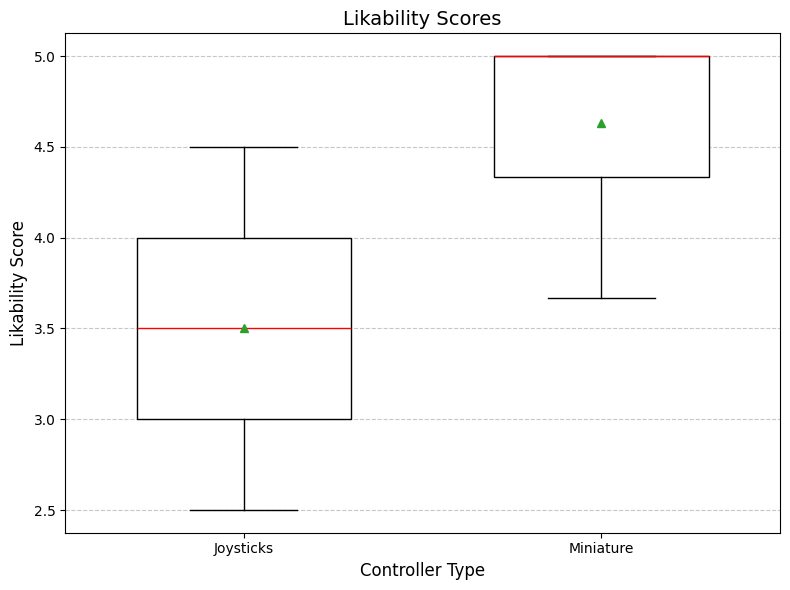

In [19]:
# Combine Likability scores for boxplot
likability_scores = [likability_joysticks, likability_miniature]

# Boxplot for Likability scores
plt.figure(figsize=(8, 6))

# Customize boxplot
bplot = plt.boxplot(
    likability_scores,
    tick_labels=['Joysticks', 'Miniature'],  # Controller labels
    patch_artist=True,                  # Enables custom box colors
    showmeans=True,                     # Displays mean as a marker
    widths=0.6                          # Width of the boxes
)

# Customize the medians
for median in bplot['medians']:
    median.set_color('red')

# Apply custom colors to the boxes
for patch, color in zip(bplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set titles and labels
plt.title("Likability Scores", fontsize=14)
plt.ylabel("Likability Score", fontsize=12)
plt.xlabel("Controller Type", fontsize=12)

# Customize ticks and grid
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


In [20]:
# Descriptive statistics for Likability scores
descriptive_stats_likability = pd.DataFrame({
    'Controller': ['Joysticks', 'Miniature'],
    'Mean': [likability_joysticks.mean(), likability_miniature.mean()],
    'Median': [likability_joysticks.median(), likability_miniature.median()],
    'Standard Deviation': [likability_joysticks.std(), likability_miniature.std()],
    'Min': [likability_joysticks.min(), likability_miniature.min()],
    'Max': [likability_joysticks.max(), likability_miniature.max()]
})

descriptive_stats_likability

,Controller,Mean,Median,Standard Deviation,Min,Max
0,Joysticks,3.50000,3.5,0.612372,2.500000,4.5
1,Miniature,4.62963,5.0,0.512197,3.666667,5.0
